<a href="https://colab.research.google.com/github/Jeiderbeltran/IA_Tizon_Tardio_Hojas_Tomate_/blob/main/IA_Tizon_Tardio_Hojas_Tomate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar dependencias
!pip install -q tensorflow tensorflow-datasets

In [ ]:
# Clonar el repositorio
!pip install -q tensorflow
from google.colab import output
!git clone https://github.com/Jeiderbeltran/IA_Tizon_Tardio_Hojas_Tomate_.git


Cloning into 'IA_Tizon_Tardio_Hojas_Tomate_'...
remote: Enumerating objects: 3518, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3518 (delta 2), reused 6 (delta 1), pack-reused 3508 (from 2)
Receiving objects: 100% (3518/3518), 117.17 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (7019/7019), done.


In [ ]:

import os
base_dir = "/content/IA_Tizon_Tardio_Hojas_Tomate_/dataset_organizado"

In [ ]:
import tensorflow as tf

BATCH_SIZE = 25
SEED = 123

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=None,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    batch_size=None,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=None,
    shuffle=False
)


Found 2464 files belonging to 2 classes.
Found 700 files belonging to 2 classes.
Found 351 files belonging to 2 classes.


In [ ]:
# Proceso de segmentacion
import numpy as np
import cv2
import matplotlib.pyplot as plt

def segment_leaf(image):
    import numpy as np
    import cv2

    img = np.array(image)

    #  Normalizar
    if img.ndim == 2:
        # Escala de grises
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.ndim == 3:
        if img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[-1] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        elif img.shape[-1] != 3:

            img = np.repeat(img[..., :1], 3, axis=-1)
    else:

        img = np.stack([img]*3, axis=-1)

    try:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    except Exception as e:
        print(f"Error al convertir a HSV. Forma de imagen: {img.shape}")


        hsv = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.COLOR_RGB2HSV)

    # Rango de color para hoja sana y enferma
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([95, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    lower_brown = np.array([10, 30, 30])
    upper_brown = np.array([25, 255, 255])
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

    mask = cv2.bitwise_or(mask_green, mask_brown)

    # Limpieza con morfología
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Segmentar hoja más grande
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        mask_clean = np.zeros_like(mask)
        cv2.drawContours(mask_clean, [c], -1, 255, -1)
        segmented = cv2.bitwise_and(img, img, mask=mask_clean)
    else:
        segmented = img

    return segmented



In [ ]:
 # Proceso de eliminacion de ruido

def denoise_image(image):
    denoised = cv2.medianBlur(image, 3)
    return denoised


In [ ]:
 # Convertir a escala de grises
def to_grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray

In [ ]:
  # Porceso de normalizacion
def normalize_image(image):
    norm = image.astype("float32") / 255.0
    return norm


In [ ]:
# Aumento de datos
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


In [ ]:
def custom_preprocessing(image, label):
    import tensorflow as tf
    import numpy as np
    import cv2


    if isinstance(image, tf.Tensor):
        image = image.numpy()

  # Escala de grises
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  # alfa
    elif image.shape[-1] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    # Etapas del preprocesamiento
    image = segment_leaf(image)
    image = denoise_image(image)
    image = to_grayscale(image)
    image = cv2.resize(image, (256, 256))
    image = normalize_image(image)

    # Expandir a (256,256,1)
    image = np.expand_dims(image, axis=-1)

    return image.astype("float32"), label


In [ ]:
def tf_wrapper(image, label):
    img, lbl = tf.py_function(
        func=custom_preprocessing,
        inp=[image, label],
        Tout=[tf.float32, tf.int32]
    )

    # Quitar dimensiones sobrantes
    img = tf.squeeze(img)
    img = tf.reshape(img, (256, 256, 1))
    lbl.set_shape(())

    return img, lbl


In [ ]:
# Aplicar al dataset
train_ds_pre = train_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
val_ds_pre   = val_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
test_ds_pre  = test_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# Aumento de datos
train_ds_pre = train_ds_pre.map(lambda x, y: (data_augmentation(x, training=True), y))


# Prefetch
train_ds_pre = train_ds_pre.prefetch(tf.data.AUTOTUNE)
val_ds_pre   = val_ds_pre.prefetch(tf.data.AUTOTUNE)
test_ds_pre  = test_ds_pre.prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models



def build_cnn(input_shape=(256, 256, 1), num_classes=2):
    model = models.Sequential([


        # Primera capa
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding="same"),
        layers.MaxPooling2D((2,2)),

        # Segunda capa
        layers.Conv2D(64, (3,3), activation='relu', padding="same"),
        layers.MaxPooling2D((2,2)),

        # Tercera capa
        layers.Conv2D(128, (3,3), activation='relu', padding="same"),
        layers.MaxPooling2D((2,2)),


        # Evitar sobreajuste
        layers.Dropout(0.3),

        # Aplanado y capa densa
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # Capa de salida
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compilación del modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Crear el modelo
cnn_model = build_cnn(input_shape=(256, 256, 1), num_classes=2)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Entrenamiento
history = cnn_model.fit(
    train_ds_pre,
    validation_data=val_ds_pre,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
 1/99 ━━━━━━━━━━━━━━━━━━━━ 12:46 8s/step - accuracy: 0.6400 - loss: 0.6848

KeyboardInterrupt: 

In [ ]:
import os
import datetime
from tensorflow.keras.models import load_model
from google.colab import files

nombre_modelo = f"modelo_tizon_v{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.keras"


best_model_path = "best_model.h5"
if not os.path.exists(best_model_path):
    raise FileNotFoundError(" No se encontró el archivo 'best_model.h5'.")


modelo = load_model(best_model_path)
modelo.save(nombre_modelo)
print(f" Modelo guardado  como: {nombre_modelo}")

FileNotFoundError:  No se encontró el archivo 'best_model.h5'.

In [ ]:
#Descargar archivo
files.download(nombre_modelo)
print(" Descarga iniciada. Espera unos segundos para guardar el archivo en tu PC.")

In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model

#  modelo desde PC
uploaded = files.upload()

nombre_modelo = list(uploaded.keys())[0]
print(f"Archivo detectado: {nombre_modelo}")

modelo = load_model(nombre_modelo)
print("Modelo cargado correctamente")




Saving modelo_tizon_v20251020_2218.keras to modelo_tizon_v20251020_2218.keras
Archivo detectado: modelo_tizon_v20251020_2218.keras
Modelo cargado correctamente


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluar el modelo
test_loss, test_acc = modelo.evaluate(test_ds_pre)
print(f"Precisión del modelo cargado: {test_acc*100:.2f}%")
print(f"Pérdida final: {test_loss:.4f}")



15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9756 - loss: 0.0599
Precisión del modelo cargado: 98.01%
Pérdida final: 0.0465


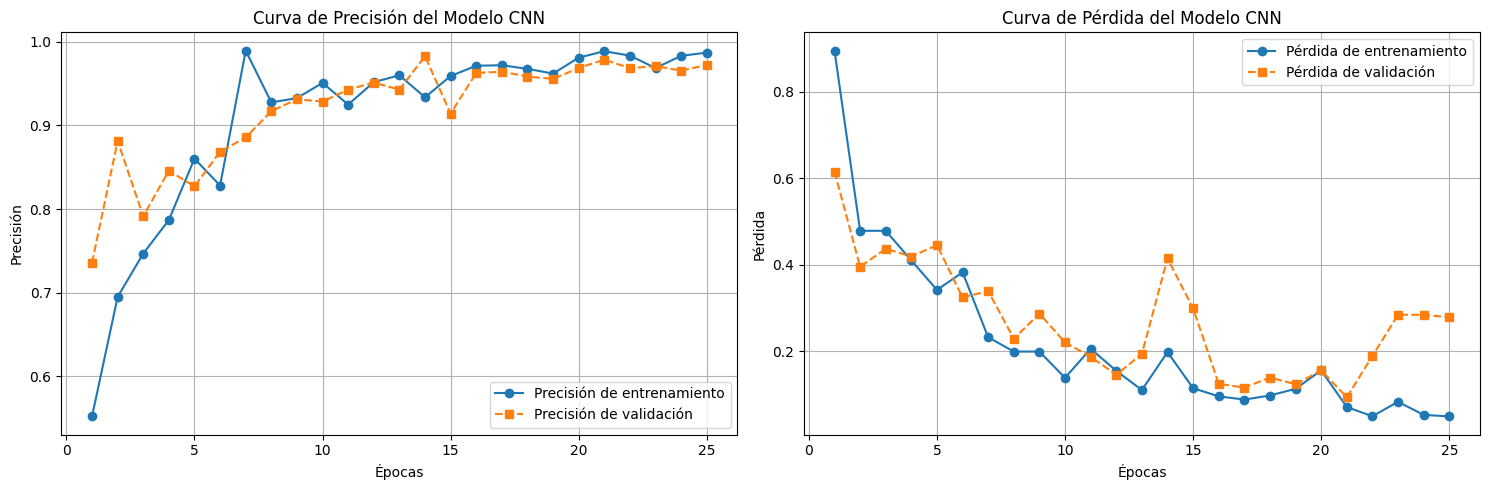

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 26))  # genera [1, 2, ..., 25]

accuracy = [0.5517, 0.6947, 0.7467, 0.7868, 0.8603,
             0.8281, 0.9896, 0.9276, 0.9328, 0.9510,
             0.9250, 0.9518, 0.9601, 0.9337, 0.9592,
             0.9715, 0.9721, 0.9678, 0.9621, 0.9812,
             0.9889, 0.9836, 0.9687, 0.9834, 0.9872]

val_accuracy = [0.7357, 0.8814, 0.7914, 0.8457, 0.8271,
                0.8686, 0.8857, 0.9171, 0.9314, 0.9286,
                0.9429, 0.9514, 0.9429, 0.9829, 0.9143,
                0.9629, 0.9643, 0.9586, 0.9557, 0.9688,
                0.9788, 0.9686, 0.9710, 0.9657, 0.9724]

loss = [0.8947, 0.4780, 0.4780, 0.4094, 0.3413,
        0.3820, 0.2316, 0.1988, 0.1986, 0.1380,
        0.2052, 0.1542, 0.1098, 0.1975, 0.1140,
        0.0951, 0.0877, 0.0971, 0.1126, 0.1552,
        0.0704, 0.0491, 0.0826, 0.0523, 0.0487]

val_loss = [0.6149, 0.3949, 0.4366, 0.4185, 0.4449,
            0.3239, 0.3386, 0.2285, 0.2865, 0.2198,
            0.1866, 0.1452, 0.1932, 0.4141, 0.2984,
            0.1243, 0.1153, 0.1387, 0.1232, 0.1552,
            0.0929, 0.1885, 0.2839, 0.2836, 0.2781]

# --- Crear subgráficas ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Curva de precisión ---
ax1.plot(epochs, accuracy, 'o-', label='Precisión de entrenamiento')
ax1.plot(epochs, val_accuracy, 's--', label='Precisión de validación')
ax1.set_title('Curva de Precisión del Modelo CNN')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Precisión')
ax1.legend()
ax1.grid(True)

# --- Curva de pérdida ---
ax2.plot(epochs, loss, 'o-', label='Pérdida de entrenamiento')
ax2.plot(epochs, val_loss, 's--', label='Pérdida de validación')
ax2.set_title('Curva de Pérdida del Modelo CNN')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Pérdida')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()




15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


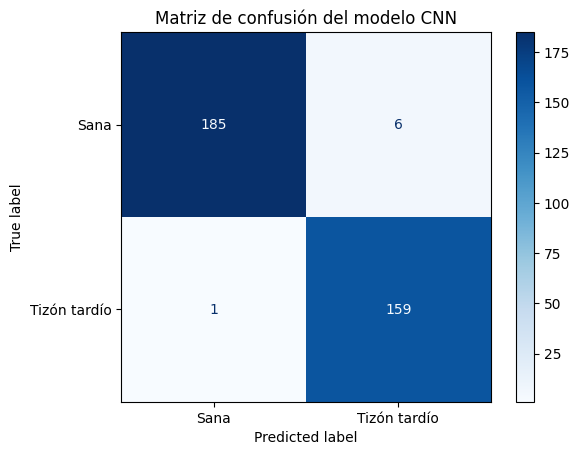

Verdaderos Negativos (TN): 185
Falsos Positivos (FP): 6
Falsos Negativos (FN): 1
Verdaderos Positivos (TP): 159


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones
y_true = np.concatenate([y for x, y in test_ds_pre], axis=0)
y_pred = np.argmax(modelo.predict(test_ds_pre), axis=1)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sana', 'Tizón tardío'])
disp.plot(cmap='Blues')
plt.title('Matriz de confusión del modelo CNN')
plt.show()

# Extraer los valores individuales
TN, FP, FN, TP = cm.ravel()

print(f"Verdaderos Negativos (TN): {TN}")
print(f"Falsos Positivos (FP): {FP}")
print(f"Falsos Negativos (FN): {FN}")
print(f"Verdaderos Positivos (TP): {TP}")

